# Setup

In [17]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt


In [18]:
# Setup some useful constants
LATENCY_MEASURES = (
    "latency min",
    "latency p50",
    "latency p90",
    "latency p99",
)

OUTPUT_PATH = "../output"

In [19]:
# Load the data, and format it so it's easy to plot graphs
files = [f for f in os.listdir(OUTPUT_PATH) if os.path.isfile(os.path.join(OUTPUT_PATH, f))]

frames = {file.split(".")[0]: pd.read_csv(os.path.join(OUTPUT_PATH, file)) for file in files}

# make a melted frame for latency
frames_melted_latency = dict()
for name in frames:
    frame = frames[name]
    melted_frame = pd.melt(frames[name], id_vars="name", var_name="measure", value_name="result")
    frames_melted_latency[name] = melted_frame.loc[melted_frame["measure"].isin(LATENCY_MEASURES)]

request_frame = pd.DataFrame(data=frames["WaitBenchmark"]["name"])
for name, frame in frames.items():
    request_frame[f"{name}"] = frame["# requests"]


In [20]:
# Some helper functions for graphs
def show_number_of_requests(name: str):
    sns.barplot(x="name", y="# requests", data=frames[name])

def show_melted_frame(frame):
    sns.catplot(x="measure", y="result", hue="name", data=frame, kind="bar")

    
def show_latency(name: str):
    show_melted_frame(frames_melted_latency[name])

# Analysis

## Background

[FastAPI](https://fastapi.tiangolo.com/) is a new kid on the Python micro-web-framework block. It promises to be
> high performance, easy to learn, fast to code, ready for production

which is enticing. But, is it much better than good 'ol dependable [Flask](https://flask.palletsprojects.com/en/1.1.x/) which doesn't even promise to be ready for production because you just *know* it is. That's the aim of this little project: do some benchmarks between the two, and see which one works best.

## Methods

### Async vs. sync
One of the biggest benefits of FastAPI is that it natively supports `async` methods, [which it claims can make it very fast](https://fastapi.tiangolo.com/benchmarks/). So I created three different implementations to test against one another:

- `flask_app`: Just regular 'ol Flask.
- `fastapi_app_sync`: FastAPI, using the default sync methods. 
- `fastapi_app_async`: FastAPI, with each method declared `async`. 

For `flask_app` and `fastapi_app_sync`, all code is shared with helpers. For `fastapi_app_async`, it uses async methods as available to try improve performance, but uses the equivalent logic. See the `helpers` folder for all the actual logic for each. 

Note that FastAPI [does not reccomend](https://fastapi.tiangolo.com/async/) using `async` if you don't `await` any calls in the function, as it's incurring overhead without any benefit. For the sake of the fairest benchmark, we did it anyway, since it
1. can always be compared to the `sync` baseline
2. gives some guidance on how much worse this actually is

### Testing methodology

To simulate and measure the impact of load, we use [wrk](https://github.com/wg/wrk) which is awesome once you get your head around lua. This allows us to specify a route, number of threads / connections, and length of a test. It outputs information about the latency and throughput. For this test, I used:
- threads: 12
- connections: 200
- duration: 60s
- timeout: 100s
- script: a custom script which outputs a large amount of information as a csv in `wrk_scripts/print_to_csv.lua`.

which translates to `wrk http://127.0.0.1:5000/{route} -t12 -c200 -d60s --timeout 100s -s wrk_scripts/print_to_csv.lua`. 

For each test, I spun up the webserver, gave it 5 seconds to initialize, run `wrk` against the route, and the used `pkill` to kill the webserver. I killed the webservers to isolate each benchmark: it was possible that `wrk` produced more load than it could handle during the test, and I didn't want one test to affect the subsequent ones. I should have been able to figure out how to kill the webservers more gracefully, but honestly `pkill` was a big hammer for this small nail, and I have videogames to play.

All webservers were run using [`gunicorn`](https://gunicorn.org/), with four workers. `FastAPI` used [`uvicorn`](https://www.uvicorn.org/) workers for better `async` support, with Flask just using Gunicorn.

Tests were done on an Ubuntu 20.04.1 LTS using Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz using 16gb of RAM.

### Benchmarks
I had five benchmarks, based off of common operations a webserver has to do, along with some toy benchmarks to try tease apart the webservers. Where relevant, I note the differences between the `sync` and `async` tests. They are:
1. `WaitBenchmark`: sleep for a second. For `fastapi_app_async`, this used an async sleep.
2. `ParseBenchmark`: parse a JSON dictionary with 10000 items, and then return it as JSON
3. `FetchBenchmark`: call a server, which sleeps for a second, and then returns. For the `sync` webservers, we used [`requests`](https://requests.readthedocs.io/en/master/), for the `async` one we used [`aiohttp`](https://docs.aiohttp.org/en/stable/), which is like requests but async.
4. `WorkBenchmark`: runs a simple `ergo` simulation for a model of Covid19 testing. This is intended to simulate a server doing a CPU bound operation, like e.g. running a ML model.
5. `DatabaseBenchmark`: write 100 entries to a database, fetch them, then delete them. All the implementations used [`SQLAlchemy`](https://www.sqlalchemy.org/) because the FastAPI docs has an example using them, with the `async` implementation using [`databases`](https://www.encode.io/databases/), which gives you an async interface for it. All requests were done against a local Postgres interface, because again FastAPI had it as an example, and what kind of benchmark would it be if I wasn't trying to do it quickly.

### Limitations
These are synthetic benchmarks, run on a single machine, for a minute. So they can reveal trends / help give some intuition about which would be faster in a real world environment, but please don't base your startup solely on this.

## Results

### WaitBenchmark
In this benchmark, we simply ask the webserver to sleep for a second. For `fastapi_app_async`, we use an async sleep method.

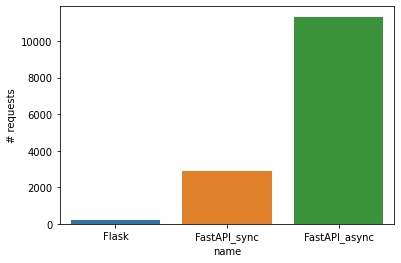

In [21]:
show_number_of_requests("WaitBenchmark")

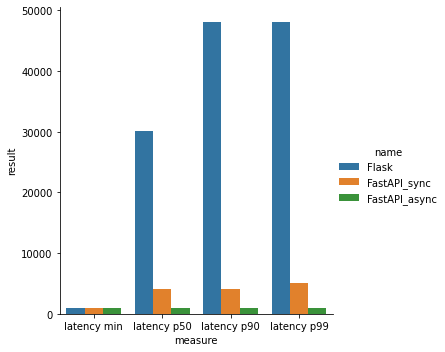

In [22]:
show_latency("WaitBenchmark")

Here we can see that FastAPI outperforms Flask handily, both in terms of throughput and latency. This supports FastAPI's claim about performance, but is a bit of an artificial measure since we're literally just sleeping. We can also see that the `async` implementation further improving over the `sync` implementation, which we would be able to parallelize sleeping really effectively.

### ParseBenchmark
To remind everyone, this is where we have webservers parse and then return a largeish piece of JSON.

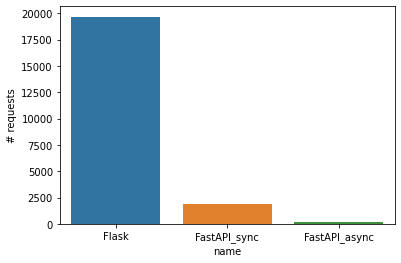

In [23]:
show_number_of_requests("ParseBenchmark")

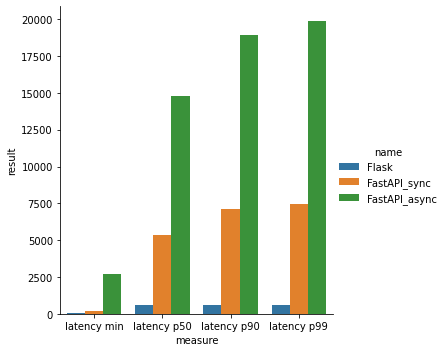

In [24]:
show_latency("ParseBenchmark")

For parsing, it seems like Flask is much, much faster for JSON parsing and returning! This might be because FastAPI does more for parsing: it creates python objects using [pydantic](https://pydantic-docs.helpmanual.io/) which is typesafe and cool, but maybe also slow looking at this benchmark. Despite the code being otherwise identical, we also see the effect of the `async` keyword on the FastAPI benchmarks, showing the expected slowdown.

### FetchBenchmark
For those following at home, this is the benchmark where we ask webservers to make a request to a server which waits a second, then returns.

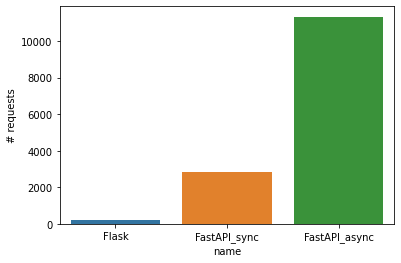

In [25]:
show_number_of_requests("FetchBenchmark")

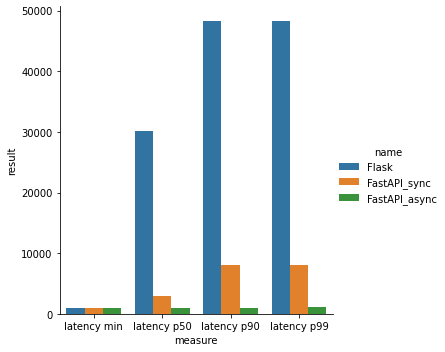

In [26]:
show_latency("FetchBenchmark")

Perhaps unsurprisingly the winner is `async` FastAPI. Since we could make the requests asynchronously, we could have much higher throughout here. More surprisingly, even though the code for FastAPI and Flask were identical, FastAPI was much faster.

### WorkBenchmark
We've now scrolled too far for you to look back above, but this is the benchmark where we ask each webserver to run a CPU intensive model.

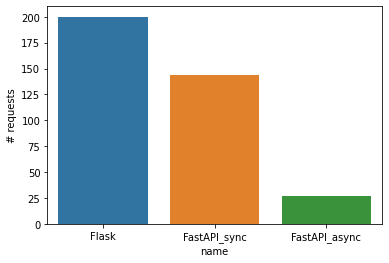

In [27]:
show_number_of_requests("WorkBenchmark")

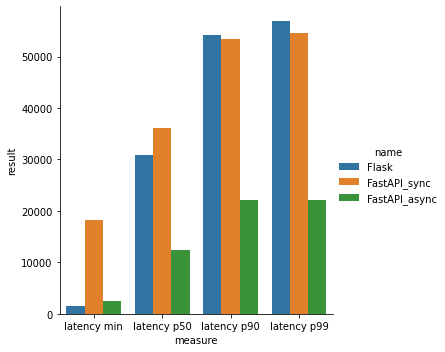

In [28]:
show_latency("WorkBenchmark")

This is the closest benchmark we've looked at so far, with Flask beating out the FastAPI throughout and latency narrowly. I'm unclear why Flask is faster here, but not for the `WaitBenchmark` - I'm guessing that ~40% might be within the margin of error for these really unscientific benchmarks. Otherwise, we again see the `async` webserver suffer due to not having any `await`ing to do.

### DatabaseBenchmark
And for last, the most realistic benchmark yet: making some create, read and delete calls to a database.

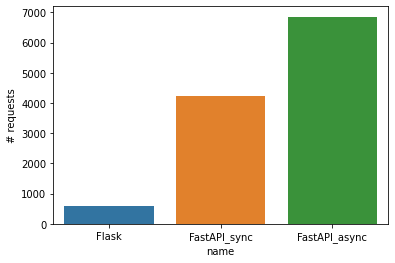

In [29]:
show_number_of_requests("DatabaseBenchmark")

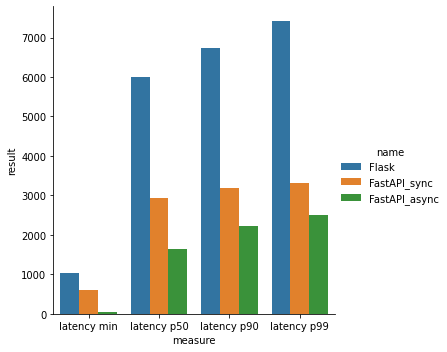

In [30]:
show_latency("DatabaseBenchmark")

Again, unsurprisingly, the `async` webserver wins out, because it can parallelize operations while the sync webservers can't. Surprisingly, the synchronous FastAPI beat out Flask by 2x throughput, and more than that for most latency, making it a pretty clear winner. 

## Discussion
Looking across all the results, we get the following for throughput

In [31]:
request_frame

,name,FetchBenchmark,WorkBenchmark,ParseBenchmark,WaitBenchmark,DatabaseBenchmark
0,Flask,236,200,19656,236,577
1,FastAPI_sync,2832,144,1912,2880,4220
2,FastAPI_async,11328,27,160,11332,6851


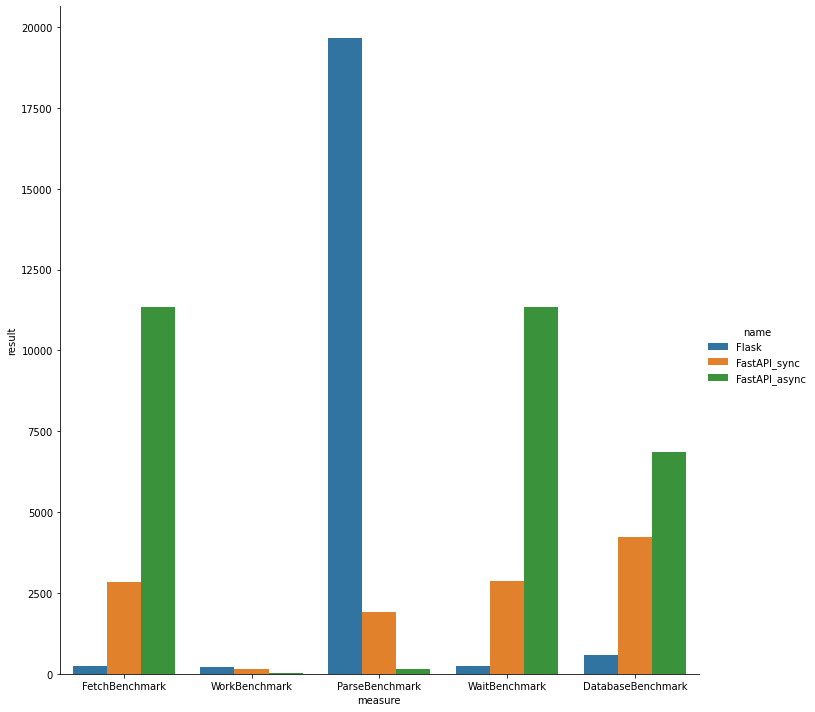

In [32]:
sns.catplot(x="measure", y="result", hue="name", data=pd.melt(request_frame, id_vars="name", var_name="measure", value_name="result"), kind="bar", height=10)

Which we can summarize as:
- For workloads that have significant waiting for i/o, using async and await using FastAPI outperforms Flask consistently
- For workloads with significant parsing requirements, Flask outperforms FastAPI by a landslide. Further investigations could include looking at seeing how Pydantic could be optimized for large workloads.
- For workloads that have large CPU workloads, we have an indication that Flask outperforms FastAPI, but given the lower throughput more investigation would be needed to fully confirm this.

## Conclusions
I think roughly, we've determined that FastAPI, at least with this toy benchmarking solution, has the potentially to outperform Flask in situations where there's a lot of I/O and not a lot of parsing JSON. This indicates that, all other things being equal, FastAPI is worth investigating further as a candidate for using in place of say Flask.